From the list of cr created from the reunion, this file will create a json listing of every deputies with their most frequent words and stopwords removed.

In [37]:
import json, math

import matplotlib.pyplot as plt

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\remib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\remib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
with open('data/processed/deputees_17.json','r',encoding='utf-8') as f:
    data = json.load(f)

with open('data/processed/communautes.json','r') as f:
    communities = json.load(f)
    

In [32]:
stop_words = set(stopwords.words('french'))

counters = []
for i,community in enumerate(communities):
    print(f"Community {i} : {len(community)} deputees")
    community_counter = Counter()
    for j,deputee_id in enumerate(community):
        print(f"  Processing deputee {j+1}/{len(community)}: {deputee_id}",end='\r')
        for phrase in data[deputee_id]['speeches']:
            token = word_tokenize(phrase.lower(), language='french')
            community_counter.update([word for word in token if word.isalpha() and word not in stop_words])
    counters.append(community_counter)
        

Community 0 : 235 deputees
Community 1 : 201 deputees35: PA721984
Community 2 : 167 deputees01: PA795808


In [56]:
doc_tfs = {}
doc_freq = {}
all_words = set()
num_communities = len(counters)


for comm_name, raw_counts in enumerate(counters):
        max_words_in_doc = max(raw_counts.values())

        augmented_tfs_for_doc = {}
        if max_words_in_doc > 0:
            for word, count in raw_counts.items():
                augmented_tfs_for_doc[word] = 0.5 + 0.5 * count / max_words_in_doc

        # Store the NORMALIZED TFs
        doc_tfs[comm_name] = augmented_tfs_for_doc

        # Update document frequency (DF)
        for word in raw_counts.keys():
            if word not in doc_freq:
                doc_freq[word] = 1
            else:
                doc_freq[word] += 1
            all_words.add(word)

print("\n--- STEP 2.2: Calculating Inverse Document Frequency (IDF) ---")

idf_scores = {}
# "Smoothed" IDF formula: log( (N+1) / (df+1) ) + 1
N = num_communities
for word in all_words:
    df = doc_freq.get(word, 0)
    idf_scores[word] = math.log((N + 1) / (df + 1))

# Create the master list of all sorted words (for consistent output order)
sorted_words = sorted(list(all_words))

print("\n--- STEP 3: Calculating TF-IDF ---")
tf_idf_by_communities = {}
for i in range(num_communities):
    print(f"Processing community {i}/{num_communities}")
    current_doc_tf = doc_tfs.get(i, {})
    tf_idf_by_communities[i] = {}
    for word in sorted_words:
        # Get normalized TF (0 if the word is not in this doc)
        tf = current_doc_tf.get(word, 0.0)
        # Get pre-calculated IDF
        idf = idf_scores.get(word, 0.0)

        # Final TF-IDF calculation
        tf_idf = tf * idf

        # Write the word and the TF-IDF score
        tf_idf_by_communities[i][word] = tf_idf
print(tf_idf_by_communities.keys())


--- STEP 2.2: Calculating Inverse Document Frequency (IDF) ---

--- STEP 3: Calculating TF-IDF ---
Processing community 0/3
Processing community 1/3
Processing community 2/3
dict_keys([0, 1, 2])


In [43]:
def plot_community_wordclouds(tf_idf_by_communities):
    """
    Plot the wordcloud
    """

    # --- 1. Configure the subplot grid ---
    num_communities = len(tf_idf_by_communities)
    # Determine the grid layout (aim for max 3 columns)
    cols = min(num_communities, 3)
    # Calculate the number of rows needed
    rows = (num_communities + cols - 1) // cols
    # Create the figure with a proportional size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 6))
    # Flatten the axes array for easy iteration
    axes_flat = axes.flatten() if num_communities > 1 else [axes]
    # --- 3. Generate one word cloud ---

    for i, (community_name, frequency_dict) in enumerate(tf_idf_by_communities.items()):
        # Determine which axis to draw on
        ax = axes_flat[i]
        # --- 3a. Generate the word cloud ---
        try:
            wc = WordCloud(width=800,
                           height=600,
                           background_color='white',
                           colormap='viridis', # Change the colormap
                           max_words=100       # Limit the number of words
                           ).generate_from_frequencies(frequency_dict)

            # --- 3b. Display on the subplot ---
            ax.imshow(wc, interpolation='bilinear')
            ax.set_title(f"Community: {community_name}")
            ax.axis('off')

        except Exception as e:
            print(f"Error generating word cloud for {community_name}: {e}")
            ax.set_title(f"WordCloud Error: {community_name}")
            ax.axis('off')

    # --- 4. Clean up unused axes ---
    # Hide subplots that were not used
    for j in range(num_communities, len(axes_flat)):
        axes_flat[j].axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=2.0)

    # Display the final plot
    print("Displaying plot...")
    plt.show()

Displaying plot...


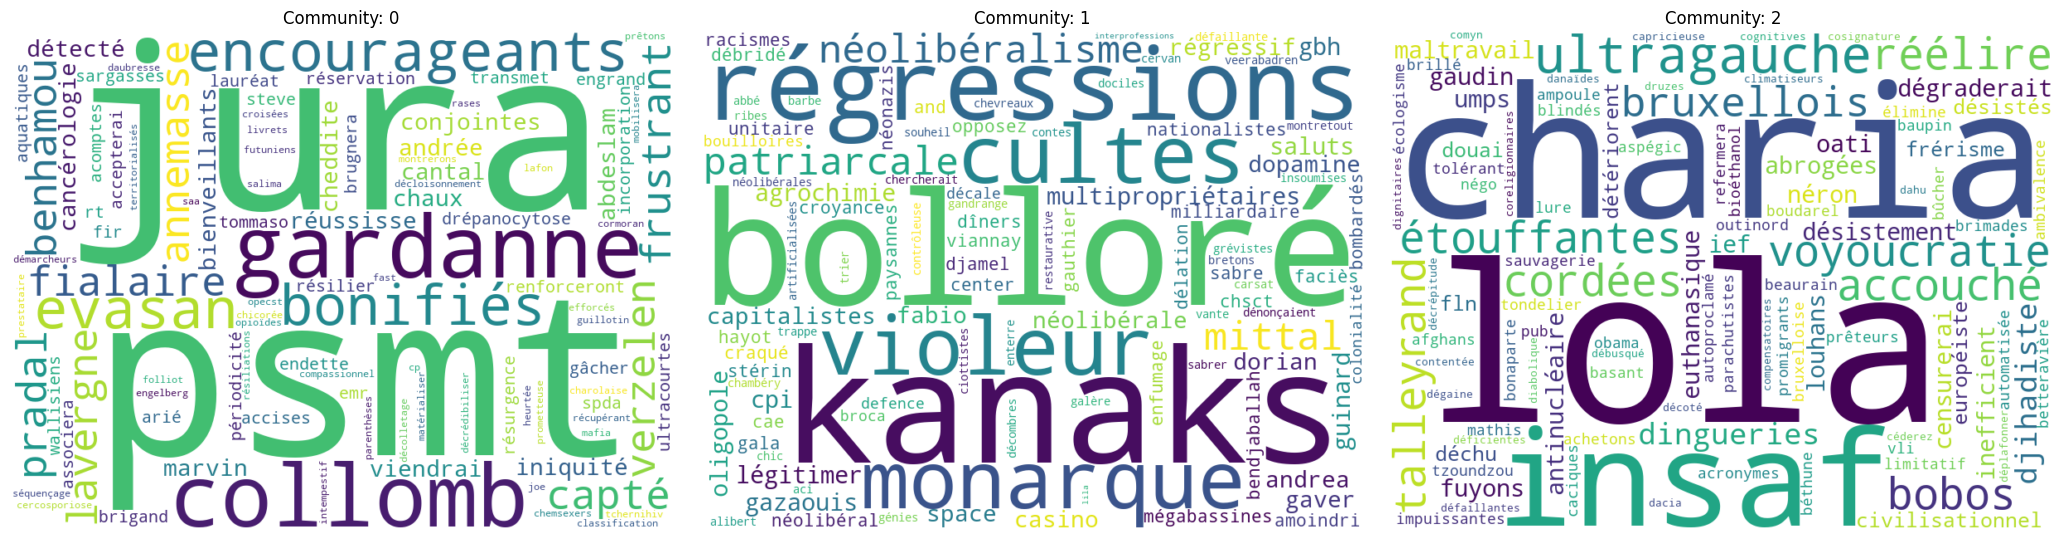

In [57]:
plot_community_wordclouds(tf_idf_by_communities)
